In [53]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.rcParams['figure.dpi']= 300
matplotlib.rcParams['figure.figsize'] = [12, 8]

In [54]:
# this loads the local file unpack.py, force reloading it if necessary
import importlib
import sys
try:
    importlib.reload(sys.modules['unpack'])
    importlib.reload(sys.modules['plotutils'])
except KeyError:
    import unpack
    import plotutils

# set these as aliases this weird way to handle reloading
plot = plotutils.plot
select = plotutils.select
overlay_flushes = plotutils.overlay_flushes

import datetime

def sec_formatter(t, _):
    dt = datetime.timedelta(seconds=t)
    return str(dt)

In [55]:
core = unpack.unpack_data('bitcoin-core')
c_commit = core['hostinfo']['git:commit'][:8]

leveldb = unpack.unpack_data('core-leveldb')
l_commit = leveldb['hostinfo']['git:commit'][:8]

c = core['frames']['updatetip']
l = leveldb['frames']['updatetip']

def rel_ctime(t):
    return t - c.index[0]

def rel_ltime(t):
    return t - l.index[0]

c = c['progress']
l = l['progress']

cx = 0
lx = 0

times = []
cvals = []
lvals = []
while cx < len(c) or lx < len(l):
    if cx >= len(c):
        times.append(rel_ltime(l.index[lx]))
        cvals.append(None)
        lvals.append(l[lx])
        lx += 1
        continue
    elif lx >= len(l):
        times.append(rel_ctime(c.index[cx]))
        cvals.append(c[cx])
        lvals.append(None)
        cx += 1
        continue
        
    ct = rel_ctime(c.index[cx])
    cv = c[cx]
    
    lt = rel_ltime(l.index[lx])
    lv = l[lx]
    
    if ct == lt:
        times.append(ct)
        cvals.append(cv)
        cx += 1
        lvals.append(lv)
        lx += 1
    elif ct < lt:
        times.append(ct)
        cvals.append(cv)
        cx += 1
        lv = lvals[-1] if lvals else None
        lvals.append(lv)
    else:
        assert lt < ct
        times.append(lt)
        lvals.append(lv)
        lx += 1
        cv = cvals[-1] if cvals else None
        cvals.append(cv)

assert len(cvals) == len(lvals) == len(times)

times = np.array([t.to_timedelta64()/1e9 for t in times], dtype=np.float64)

c_flushes = list(core['frames']['flushes'].index - c.index[0])
l_flushes = list(leveldb['frames']['flushes'].index - l.index[0])

c_flushes = np.array([t.to_timedelta64()/1e9 for t in c_flushes], dtype=np.float64)
l_flushes = np.array([t.to_timedelta64()/1e9 for t in l_flushes], dtype=np.float64)

df = pd.DataFrame({
    'master ' + c_commit: cvals,
    'eklitzke ' + l_commit: lvals,
    't': times,
}, index=times)

Loading data from input file /home/evan/logs/bitcoin-core-1518996011.log
Loading data from input file /home/evan/logs/core-leveldb-1519046130.log


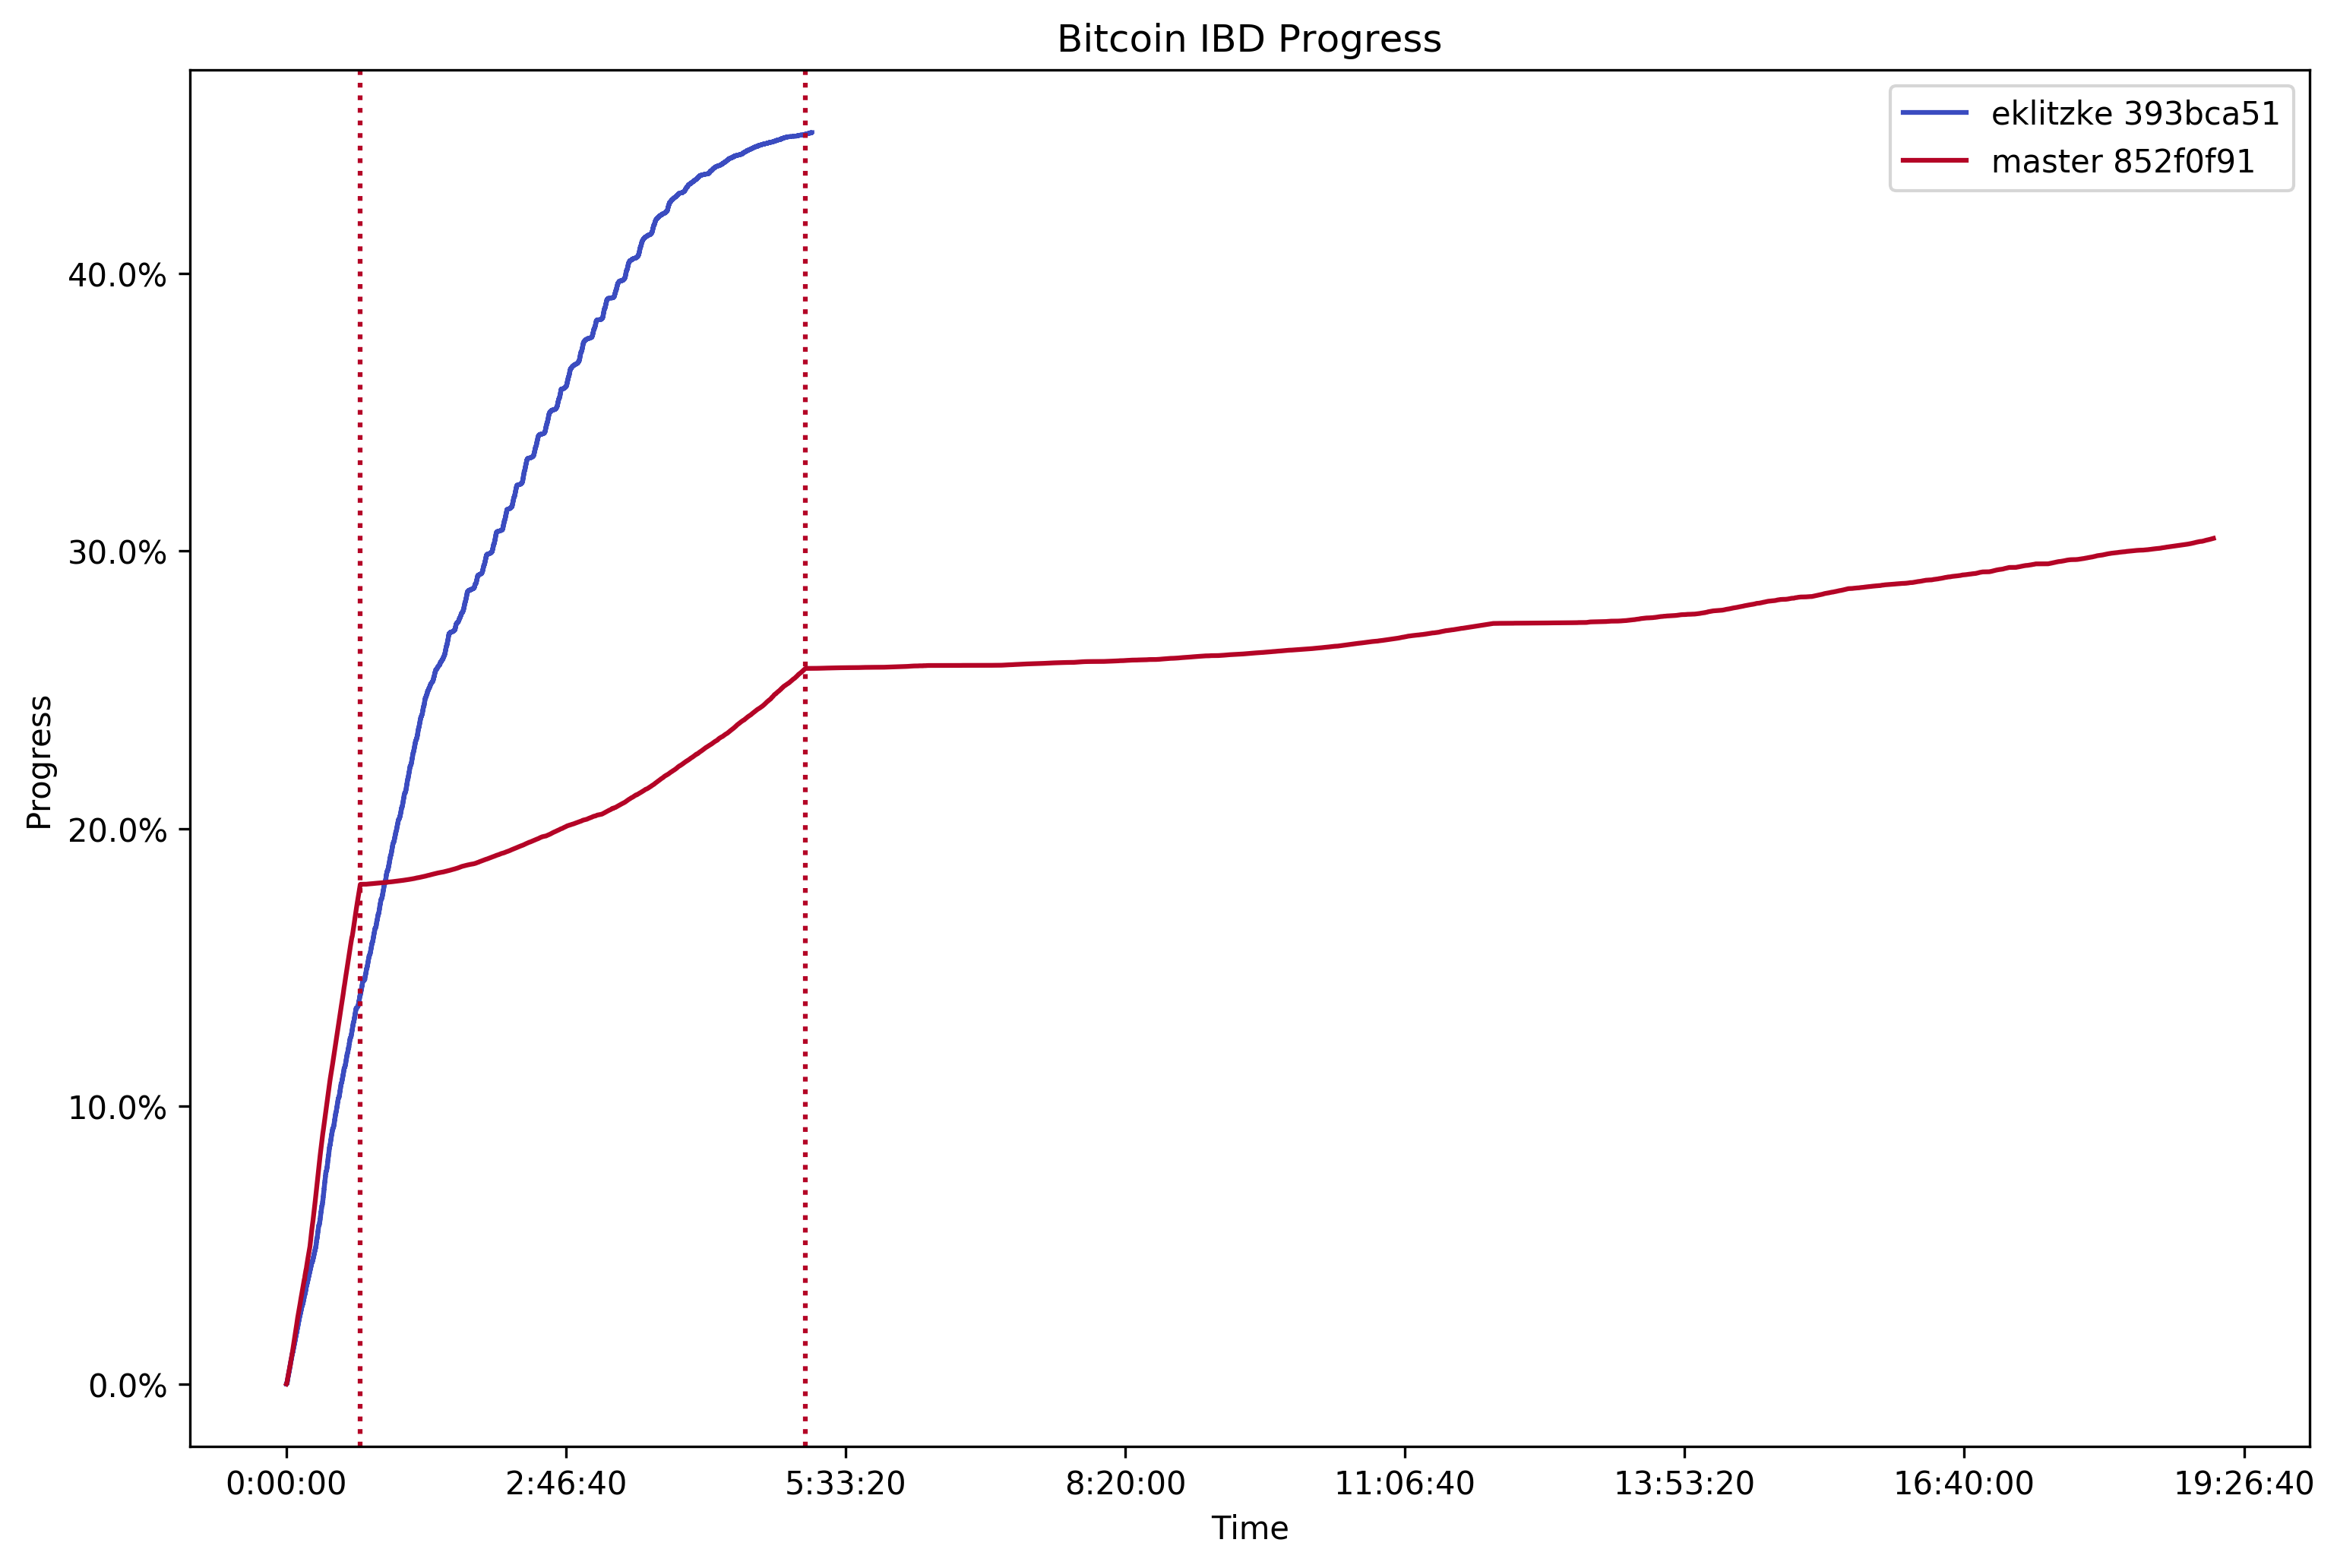

In [56]:
import matplotlib.ticker as mtick
from matplotlib import cm

cmap = cm.get_cmap('coolwarm')

columns = list(sorted(c for c in df.columns if c != 't'))

fig = plt.figure()
ax = (df[columns] * 100).plot(colormap=cmap)
ax.set_xlabel('Time')
ax.set_ylabel('Progress')
ax.set_title('Bitcoin IBD Progress')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.FuncFormatter(sec_formatter))

#for x in l_flushes:
#    plt.axvline(x=x, color=cmap(0.0), linestyle=':') 

for x in c_flushes:
    plt.axvline(x=x, color=cmap(1.0), linestyle=':')   